In [16]:
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torch.utils.data as data_utils
import numpy as np
# standards
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# ffjord
from ffjord import ffjordSL
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [5]:
args = ffjordSL.ffjord_args(num_epochs=50, add_noise=False)

In [6]:
train_set, test_loader, data_shape = ffjordSL.get_dataset(args)

In [7]:
train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=args.batch_size, shuffle=False, drop_last=True
    )

X_train: torch.Size([200, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([200]) type: torch.LongTensor


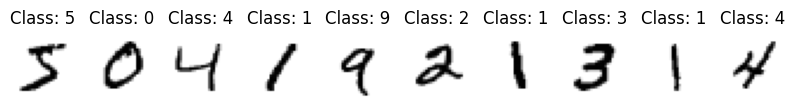

In [8]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))

# batch_size >=10
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## Build model and tools

In [6]:
# build model
regularization_fns, regularization_coeffs = ffjordSL.create_regularization_fns(args)
ffjord_model = ffjordSL.create_model(args, (1,28,28), regularization_fns)

In [4]:
# load model
ffjord_model, args = torch.load('E:/Python/ChinaLake/CCU_ffjord/experiments/base_mnist_epoch1_loss-6.138068675994873')

In [81]:
args.begin_epoch = 2 # starting where we left off

In [91]:
args.num_epochs = 45

In [92]:
ffjord_model_t, loss_hist = ffjordSL.ffjord_train(ffjord_model, args,
                      train_set,
                      test_loader,
                      exp_name = 'base_mnist')

epoch: 2 -- itr: 0 -- loss -10.939873695373535
epoch: 2 -- itr: 1 -- loss -11.008517265319824
epoch: 2 -- itr: 2 -- loss -10.775885581970215
epoch: 2 -- itr: 3 -- loss -10.75393295288086
epoch: 2 -- itr: 4 -- loss -10.944164276123047
epoch: 2 -- itr: 5 -- loss -10.732478141784668
epoch: 2 -- itr: 6 -- loss -10.950037956237793
epoch: 2 -- itr: 7 -- loss -10.917763710021973
epoch: 2 -- itr: 8 -- loss -10.966464042663574
epoch: 2 -- itr: 9 -- loss -10.935205459594727
epoch: 2 -- itr: 10 -- loss -10.863773345947266
epoch: 2 -- itr: 11 -- loss -10.99330997467041
epoch: 2 -- itr: 12 -- loss -11.154256820678711
epoch: 2 -- itr: 13 -- loss -10.986434936523438
epoch: 2 -- itr: 14 -- loss -10.893906593322754
epoch: 2 -- itr: 15 -- loss -10.94277572631836
epoch: 2 -- itr: 16 -- loss -11.129772186279297
epoch: 2 -- itr: 17 -- loss -11.144969940185547
epoch: 2 -- itr: 18 -- loss -11.006765365600586
epoch: 2 -- itr: 19 -- loss -11.090432167053223
epoch: 2 -- itr: 20 -- loss -10.918000221252441
epoch

KeyboardInterrupt: 

In [ ]:
Python/ChinaLake/CCU_ffjord/experiments/base_mnist_epoch10.pth

In [93]:
# load model
ffjord_model, args = torch.load('E:/Python/ChinaLake/CCU_ffjord/experiments/base_mnist_epoch10.pth')

In [20]:
for (xf, yf) in test_loader:
    if not args.conv:
        xf = xf.view(xf.shape[0], -1)
    #xf = cvt(xf)
    loss,z,logpx = ffjordSL.compute_bits_per_dim(xf, ffjord_model)
    break

In [17]:
norm_in_class_in = []
for i in yf.unique():
    print(f'class: {i} -- mean in: {logpx[yf==i].mean()}\n')
    norm_in_class_in.append(logpx[yf==i].mean().detach().cpu())
print(f'in class normalized mean: {np.array(norm_in_class_in).mean()}')

class: 0 -- mean in: 11317.435546875

class: 1 -- mean in: 14465.6689453125

class: 2 -- mean in: 11529.759765625

class: 3 -- mean in: 12071.01953125

class: 4 -- mean in: 12446.216796875

class: 5 -- mean in: 11909.69921875

class: 6 -- mean in: 11996.9833984375

class: 7 -- mean in: 12650.9599609375

class: 8 -- mean in: 11535.1630859375

class: 9 -- mean in: 12516.8037109375

in class normalized mean: 12243.970703125


In [10]:
norm_in_class_in = []
for i in yf.unique():
    print(f'class: {i} -- mean in: {logpx[yf==i].mean()}\n')
    norm_in_class_in.append(logpx[yf==i].mean().detach().cpu())
print(f'in class normalized mean: {np.array(norm_in_class_in).mean()}')

class: 0 -- mean in: 7341.93798828125

class: 1 -- mean in: 8603.26953125

class: 2 -- mean in: 7452.37890625

class: 3 -- mean in: 7708.556640625

class: 4 -- mean in: 7837.73583984375

class: 5 -- mean in: 7650.69873046875

class: 6 -- mean in: 7650.5478515625

class: 7 -- mean in: 7941.4140625

class: 8 -- mean in: 7324.34130859375

class: 9 -- mean in: 7774.716796875

in class normalized mean: 7728.56005859375


In [11]:
noise_f = torch.rand(100*28*28)
noise_f = noise_f.reshape((100,1,28,28))
loss,z,logpxn = ffjordSL.compute_bits_per_dim(noise_f, ffjord_model)
logpxn.mean()

tensor(-1277.4567, device='cuda:0', grad_fn=<MeanBackward0>)

In [12]:
logpx.shape

torch.Size([200, 1])

## Create a manipulator to transform from one to another

In [94]:
z = torch.Tensor([])
y = torch.Tensor([])
for (xf, yf) in test_loader:
    if not args.conv:
        xf = xf.view(xf.shape[0], -1)
    #xf = cvt(xf)
    loss,zf,logpx = ffjordSL.compute_bits_per_dim(xf, ffjord_model)
    z = torch.concatenate((z, zf.cpu().detach()))
    y = torch.concatenate((y, yf.cpu().detach()))
    

In [73]:
z.shape

torch.Size([10000, 784])

In [74]:
y.shape

torch.Size([10000])

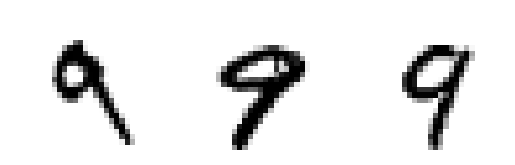

In [76]:
generated_samples = ffjord_model(z[y==9][0:3], reverse=True)
generated_samples = generated_samples.cpu().detach().numpy()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(generated_samples[i].reshape(28,28), cmap="gray_r")


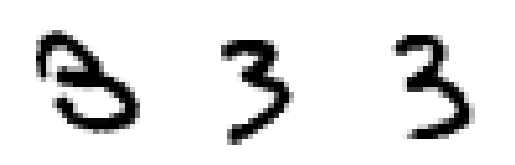

In [77]:
generated_samples = ffjord_model(z[y==3][0:3], reverse=True)
generated_samples = generated_samples.cpu().detach().numpy()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(generated_samples[i].reshape(28,28), cmap="gray_r")

In [95]:
means = torch.Tensor([])
for i in range(10):
    means = torch.concatenate((means, z[y==i].mean(dim=0).cpu().detach()))

In [96]:
means = means.reshape((10,784))

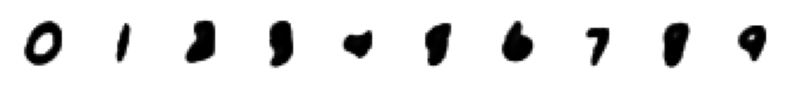

In [128]:
plt.figure(figsize=(10*pltsize, pltsize))
generated_samples = ffjord_model(means, reverse=True)
generated_samples = generated_samples.cpu().detach().numpy()
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(generated_samples[i].reshape(28,28), cmap="gray_r")

In [103]:
samps = z[y==7][0:2]

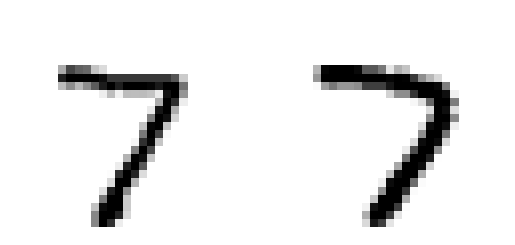

In [105]:
generated_samples = ffjord_model(samps, reverse=True)
generated_samples = generated_samples.cpu().detach().numpy()
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.axis('off')
    plt.imshow(generated_samples[i].reshape(28,28), cmap="gray_r")

In [106]:
means[9]

torch.Size([784])

In [109]:
samps

tensor([[-0.6706, -0.1378, -0.8170,  ..., -1.8419, -0.3534,  0.8853],
        [-0.7507, -0.2087, -0.2990,  ...,  0.9793, -0.6037,  0.5897]])

In [141]:
samps.shape

torch.Size([2, 784])

In [108]:
samps + means[9]

tensor([[-1.3136, -0.1050, -1.5166,  ..., -1.9733, -0.6349,  1.4559],
        [-1.3937, -0.1760, -0.9985,  ...,  0.8479, -0.8852,  1.1603]])

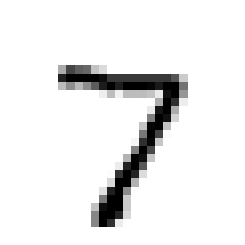

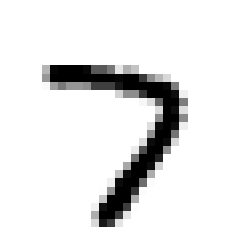

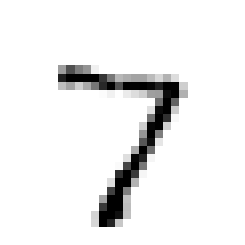

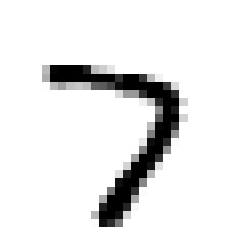

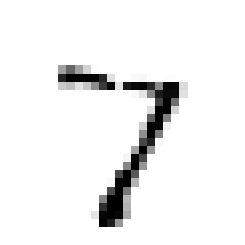

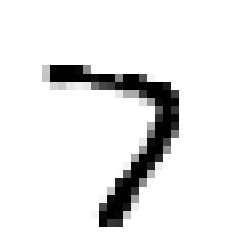

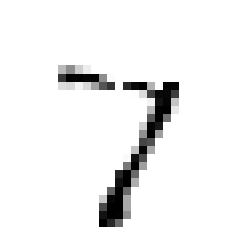

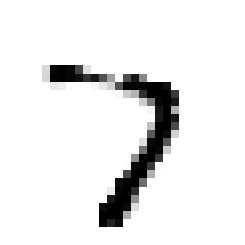

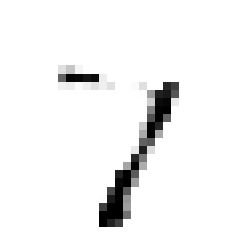

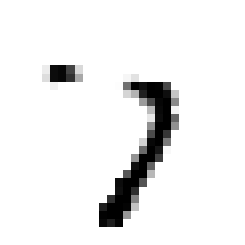

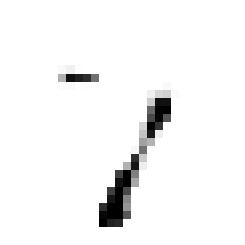

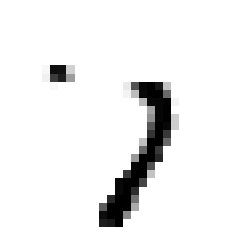

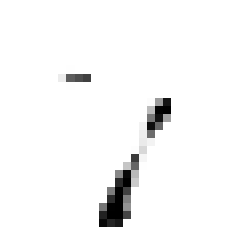

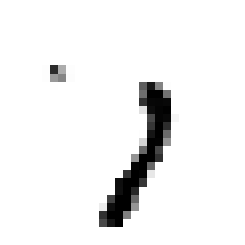

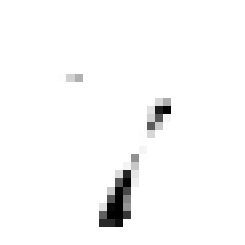

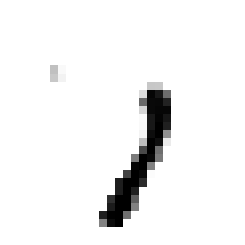

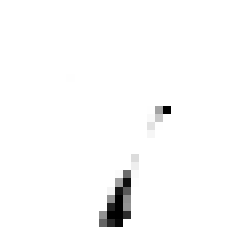

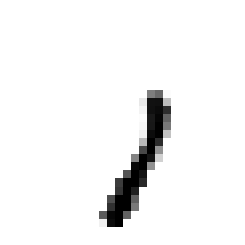

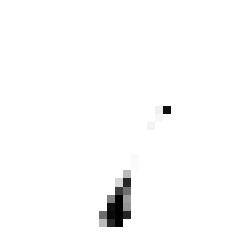

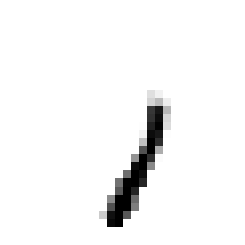

In [111]:
for i in range(10):
    generated_samples = ffjord_model(samps + (means[9]*(.1*i)), reverse=True)
    generated_samples = generated_samples.cpu().detach().numpy()
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.imshow(generated_samples[i].reshape(28,28), cmap="gray_r")
        plt.show()

In [155]:
import scipy.interpolate as interp

# Create a 1D array of x-values
x = np.array([1, 2, 3, 4, 5])

# Create a 1D array of y-values
y = np.array([2, 4, 6, 8, 10])

# Create an interp1d function
f = interp.interp1d(x, y)

# Interpolate the value at the mean of the x-values
y_interp = f(x)

# Print the interpolated value
print(y_interp)

[ 2.  4.  6.  8. 10.]


In [151]:
from scipy.interpolate import Rbf

# Create a radial basis function interpolator
interp = Rbf(samps[0], means[9])

# Interpolate the value at a new point
new_x = np.array([samps + (means[9]*(.1*i)) for i in range(10)])
new_y = np.array([interp(new_xi) for new_xi in new_x])

# Print the interpolated value
print(new_y)

ValueError: `y` must be a 2-dimensional array.

In [162]:
interp = Rbf(np.array([np.zeros(784)+1,np.zeros(784)+3]), np.array([samps[0], means[9]]))

LinAlgError: Matrix is singular.

In [159]:
np.array([samps[0], means[9]]).shape

(2, 784)

In [160]:
np.array([1,3]).shape

(2,)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [146]:
[samps + (means[9]*(.1*i)) for i in range(10)]

[tensor([[-0.6706, -0.1378, -0.8170,  ..., -1.8419, -0.3534,  0.8853],
         [-0.7507, -0.2087, -0.2990,  ...,  0.9793, -0.6037,  0.5897]]),
 tensor([[-0.7349, -0.1345, -0.8870,  ..., -1.8550, -0.3816,  0.9424],
         [-0.8150, -0.2054, -0.3689,  ...,  0.9662, -0.6319,  0.6467]]),
 tensor([[-0.7992, -0.1313, -0.9569,  ..., -1.8682, -0.4097,  0.9994],
         [-0.8793, -0.2022, -0.4389,  ...,  0.9531, -0.6600,  0.7038]]),
 tensor([[-0.8635, -0.1280, -1.0269,  ..., -1.8813, -0.4379,  1.0565],
         [-0.9436, -0.1989, -0.5088,  ...,  0.9399, -0.6881,  0.7609]]),
 tensor([[-0.9278, -0.1247, -1.0968,  ..., -1.8944, -0.4660,  1.1136],
         [-1.0079, -0.1956, -0.5788,  ...,  0.9268, -0.7163,  0.8179]]),
 tensor([[-0.9921, -0.1214, -1.1668,  ..., -1.9076, -0.4942,  1.1706],
         [-1.0722, -0.1923, -0.6488,  ...,  0.9136, -0.7444,  0.8750]]),
 tensor([[-1.0564, -0.1181, -1.2368,  ..., -1.9207, -0.5223,  1.2277],
         [-1.1365, -0.1891, -0.7187,  ...,  0.9005, -0.7726,  0.9

In [150]:
interp(samps[0])

array([-0.34375  ,  0.078125 , -0.875    , -0.21875  , -1.1875   ,
       -0.84375  , -0.375    , -0.5625   , -1.       , -0.15625  ,
       -1.09375  , -0.28125  ,  0.71875  , -0.359375 , -2.3125   ,
        2.3125   ,  1.25     ,  0.3984375, -0.0078125,  0.6328125,
        1.03125  ,  0.8125   ,  0.75     ,  0.578125 ,  0.15625  ,
        0.84375  ,  0.796875 ,  1.5      ,  0.203125 , -1.078125 ,
        0.1484375, -0.25     , -0.375    , -0.234375 , -0.15625  ,
       -0.28125  ,  0.1875   ,  0.046875 , -0.1875   , -0.109375 ,
       -0.359375 , -1.5      ,  2.9375   ,  0.       ,  1.375    ,
        0.46875  ,  0.875    ,  0.625    , -0.015625 ,  0.171875 ,
       -0.28125  ,  0.1875   ,  0.6875   ,  0.78125  ,  0.125    ,
        0.8203125,  0.25     , -0.75     ,  0.421875 ,  0.359375 ,
       -0.875    , -0.03125  , -0.875    ,  0.59375  ,  0.       ,
       -0.0625   ,  0.34375  ,  0.65625  ,  0.15625  , -0.46875  ,
       -0.21875  ,  0.578125 ,  0.90625  ,  0.09375  ,  0.1562

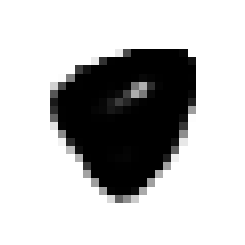

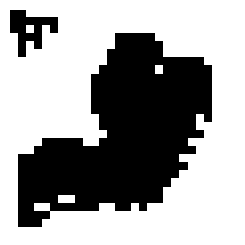

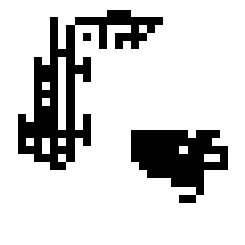

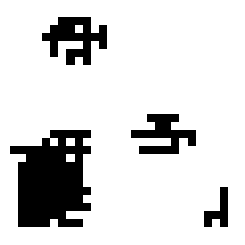

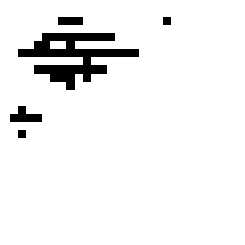

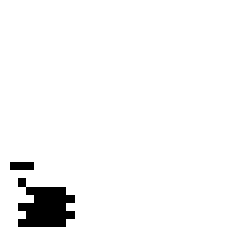

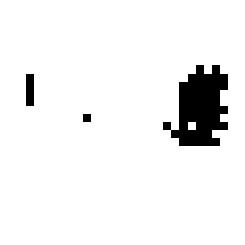

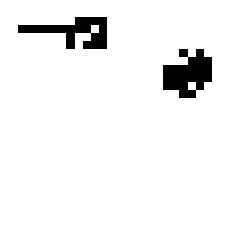

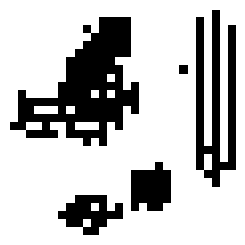

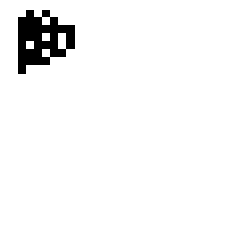

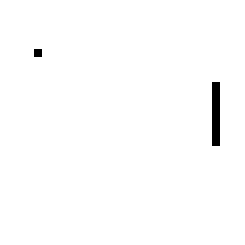

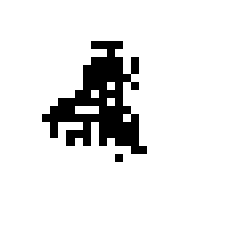

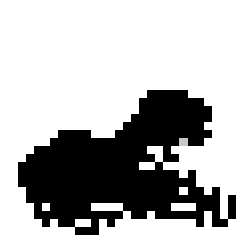

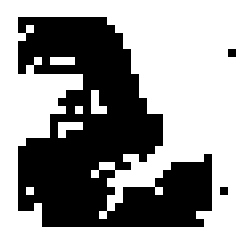

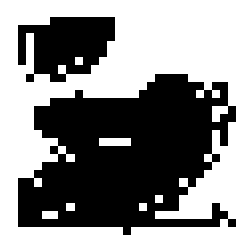

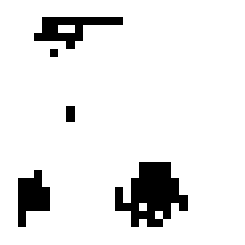

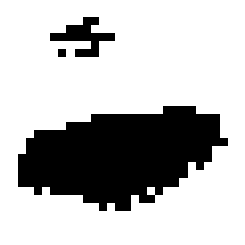

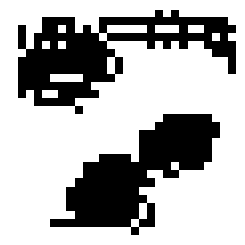

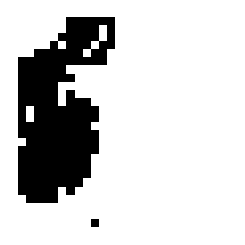

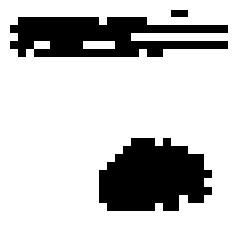

In [144]:
for i in range(10):
    generated_samples = ffjord_model(torch.Tensor(new_y[i]), reverse=True)
    generated_samples = generated_samples.cpu().detach().numpy()
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.imshow(generated_samples[i].reshape(28,28), cmap="gray_r")
        plt.show()

In [124]:
np.zeros((3,3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [123]:
np.linspace(0, 1, 3)

array([0. , 0.5, 1. ])

In [127]:
def create_line(start_point, end_point, dimensions):
    
    """Creates a line from one point to another in hyperdimensional space.

  Args:
    start_point: A numpy array representing the starting point of the line.
    end_point: A numpy array representing the ending point of the line.
    dimensions: The number of dimensions in the hyperdimensional space.

  Returns:
    A numpy array representing the line.
      """

    line = np.zeros((dimensions,10))
    for i in range(dimensions):
        line[i] = start_point[i] + (end_point[i] - start_point[i]) * np.linspace(0, 1, 10)
    return line

# Example usage:

start_point = np.array([1, 2, 3])
end_point = np.array([4, 5, 6])
dimensions = 3

line = create_line(start_point, end_point, dimensions)

print(line.T)

[[1.         2.         3.        ]
 [1.33333333 2.33333333 3.33333333]
 [1.66666667 2.66666667 3.66666667]
 [2.         3.         4.        ]
 [2.33333333 3.33333333 4.33333333]
 [2.66666667 3.66666667 4.66666667]
 [3.         4.         5.        ]
 [3.33333333 4.33333333 5.33333333]
 [3.66666667 4.66666667 5.66666667]
 [4.         5.         6.        ]]


In [ ]:
def get_manipulator(index):
    z_pos = [z[i] for i in range(len(x)) if attr[i][index] == 1]
    z_neg = [z[i] for i in range(len(x)) if attr[i][index] == -1]

    z_pos = np.mean(z_pos, axis=0)
    z_neg = np.mean(z_neg, axis=0)
    return z_pos - z_neg
_TAGS = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
_TAGS = _TAGS.split()

z_manipulate = [get_manipulator(i) for i in range(len(_TAGS))]
z_manipulate = 1.6 * np.array(z_manipulate, dtype=np.float32)